## Machine Learning Final Project  

#### Jiachen Huang and Yijing Zhou

#### All data uploaded on google drive: https://drive.google.com/drive/folders/1QBBFb9A2wDPoiHdLvTy-6tjB1vXA7fak?usp=sharing

In [41]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import urllib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import math

matplotlib.rcParams['font.family'] = 'SimHei'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("ganji.csv")
zh = pd.read_csv("zhuzhai.csv")

### preprocessing data (regular expression + getting dummies)

In [4]:
df = df[pd.notnull(df['价格(price)'])]
zh=zh[zh['adname'] == "上海市"]
df=df.drop(['Unnamed: 22'], axis=1)
df=df.dropna(axis=0,how='any')
df.shape

(35627, 22)

In [5]:
df['price']=df['价格(price)'].str.extract('(\d+)').astype(float)
df['size']=df['面积(size)'].str.extract('(\d+)').astype(float)
df['p2s']=df['price']/df['size']

In [6]:
df=df[df["小区名称(community)"].isin(zh["name"])]
df = df.rename(columns={"小区名称(community)": "name"})

In [7]:
df.shape

(18270, 25)

In [8]:
df=pd.merge(df, zh, on='name')
df = df.reset_index(drop=True)

In [9]:
df=df.drop(["房源标题(title)","tel",'pname',"更新时间(update_time)",
            "经纪人公司(company)","信息ID(puid)",'省份(province)', '城市(city)','Unnamed: 9',"type"], axis=1)

In [10]:
housetype = df['户型(type)'].value_counts()

In [11]:
#type
df[['type_room', 'type_hall', 'type_bathroom']] = df['户型(type)'].str.extract('(\d+)室(\d+)厅(\d+)卫', expand=False).astype(float)

In [12]:
#payment
price_type = pd.get_dummies(df['付款方式(price_type)'],drop_first = True)
price_type.columns = ['payment_0d6p','payment_0d12p','payment_12p','payment_1d1p','payment_1d3p','payment_1d2p',
                      'payment_1d6p','payment_1d12p','payment_2d1p','payment_2d3p','payment_2d2p','payment_0d']
df = pd.concat([df,price_type],axis=1)

In [13]:
#elevator
df['电梯情况(elevator)'].describe()
df['电梯情况(elevator)'] = df['电梯情况(elevator)'].replace("无","无电梯")
elevator_type = pd.get_dummies(df['电梯情况(elevator)'],drop_first=True)
elevator_type.columns = ['elevator']
df = pd.concat([df,elevator_type],axis=1)

In [14]:
#district
x = df['所在地址(location)'].str.split(",").str[0]
df['district'] = x.str.split('"').str[1]
df['district'] = df['district'].replace(np.nan, "未知")
district_type = pd.get_dummies(df['district'],drop_first = True)
district_type.columns = ['district_nanhui','district_luwan','district_jiading','district_fengxian',
                         'district_baoshan','district_chongming','district_xuhui','district_putuo',
                         'district_unknown','district_yangpu','district_songjiang','district_pudong',
                         'district_hongkou','district_jinshan','district_changning','district_minhang',
                         'district_zhabei','district_qingpu','district_jingan','district_huangpu']
df = pd.concat([df,district_type],axis=1)

In [15]:
#totalfloors + floor types
df['楼高'] = df['楼层(floor)'].str.split("/").str[0]
df['总楼层'] = df['楼层(floor)'].str.split("/").str[1]

df['totalfloors'] = df['总楼层'].str.extract('共(\d+)层', expand=False).astype(float)
df = df.drop(columns = ['总楼层'])

df['楼高'] = df['楼高'].replace("共1层","低层")
df['楼高'] = df['楼高'].replace("共2层","低层")
df['楼高'] = df['楼高'].replace("共3层","低层")
df['楼高'] = df['楼高'].replace("共4层","低层")
df['楼高'] = df['楼高'].replace("共5层","低层")
height = pd.get_dummies(df['楼高'])
height.columns = ['floor_middle','floor_low','floor_underground','floor_high']
df = pd.concat([df,height],axis=1)
df = df.drop(columns = ['floor_underground','楼高'])

In [16]:
#direction
direction = pd.get_dummies(df['朝向(direction)'],drop_first=True)
direction.columns = ['direction_SE','direction_E','direction_EW','direction_N','direction_SN','direction_S','direction_WN','direction_WS','direction_W']
df = pd.concat([df,direction],axis=1)

In [17]:
#decoration
df['装修情况(decoration)'].describe()
decoration = pd.get_dummies(df['装修情况(decoration)'],drop_first=True)
decoration.columns = ['decoration_simple','decoration_fine','decoration_luxury']
df = pd.concat([df,decoration],axis=1)

### Some plots and visualization

#### 1. plot of correlation

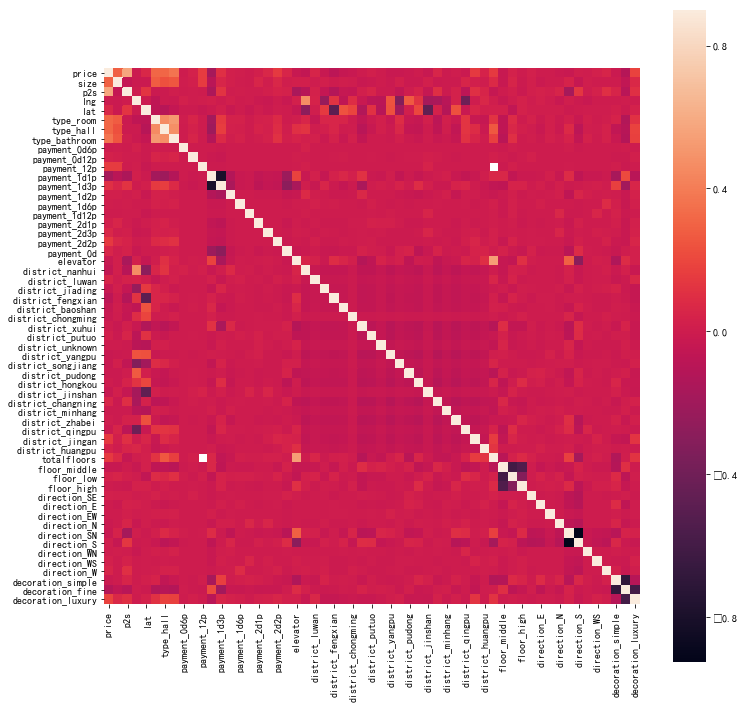

In [18]:
corrmat = df.corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

#### 2. plot of size distribution

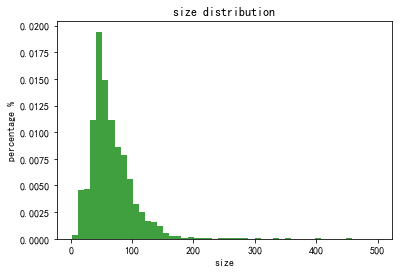

In [19]:
size_new = []
for x in df['size']:
    if  x < 500:
        size_new.append(x)
        
n, bins, patches = plt.hist(size_new, 50, normed=1, facecolor='green', alpha=0.75)
plt.title('size distribution')    
plt.xlabel('size') 
plt.ylabel('percentage %')
plt.show()

#### 3. plot of price distribution

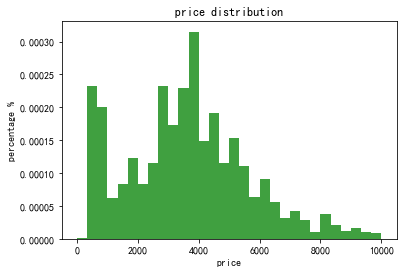

In [20]:
new_x = []
for x in df['price']:
    if  x < 10000:
        new_x.append(x)
n, bins, patches = plt.hist(new_x , 30, normed=1, facecolor='green', alpha=0.75)
plt.title('price distribution')    
plt.xlabel('price') 
plt.ylabel('percentage %')
plt.show()

#### 4. housetype plot

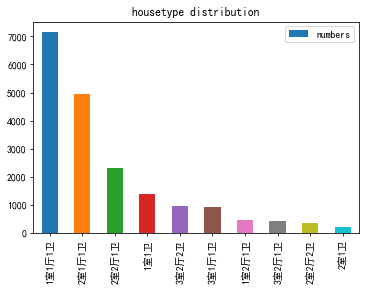

In [21]:
from pylab import mpl
mpl.rcParams['axes.unicode_minus'] = False 
asd,sdf = plt.subplots(1,1,dpi=70)
housetype.head(10).plot(kind='bar',x='housetype',y='size',title='housetype distribution',ax=sdf)
plt.legend(['numbers'])
plt.show()

In [22]:
#cut size into 7 ranges
area_level = [0, 50, 100, 150, 200, 250, 300, 500] 
label_level = ['小于50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350']
size_cut = pd.cut(df['size'],area_level,label_level)
acreage = size_cut.value_counts()
acreage

(50, 100]     9535
(0, 50]       7664
(100, 150]    2071
(150, 200]     231
(300, 500]      78
(250, 300]      69
(200, 250]      61
Name: size, dtype: int64

#### 5. price by size distribution plot

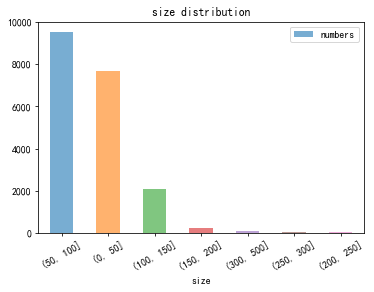

In [23]:
asd,sdf = plt.subplots(1,1,dpi=70)
acreage.plot(kind='bar',rot=30,alpha=0.6,ax=sdf)
plt.title('size distribution')    
plt.xlabel('size')    
plt.legend(['numbers'])    
plt.show()

#### 6. price by district plot

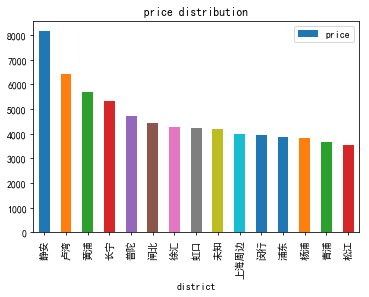

In [24]:
region_mean = df.groupby('district').mean()['price'].sort_values(ascending=False)
asd,sdf = plt.subplots(1,1,dpi=70)
#top 15 regions
region_mean.head(15).plot(kind='bar',x='region',y='mean',title='price distribution',ax=sdf)   
plt.legend(['price'])
plt.show()

#### 7. Variable

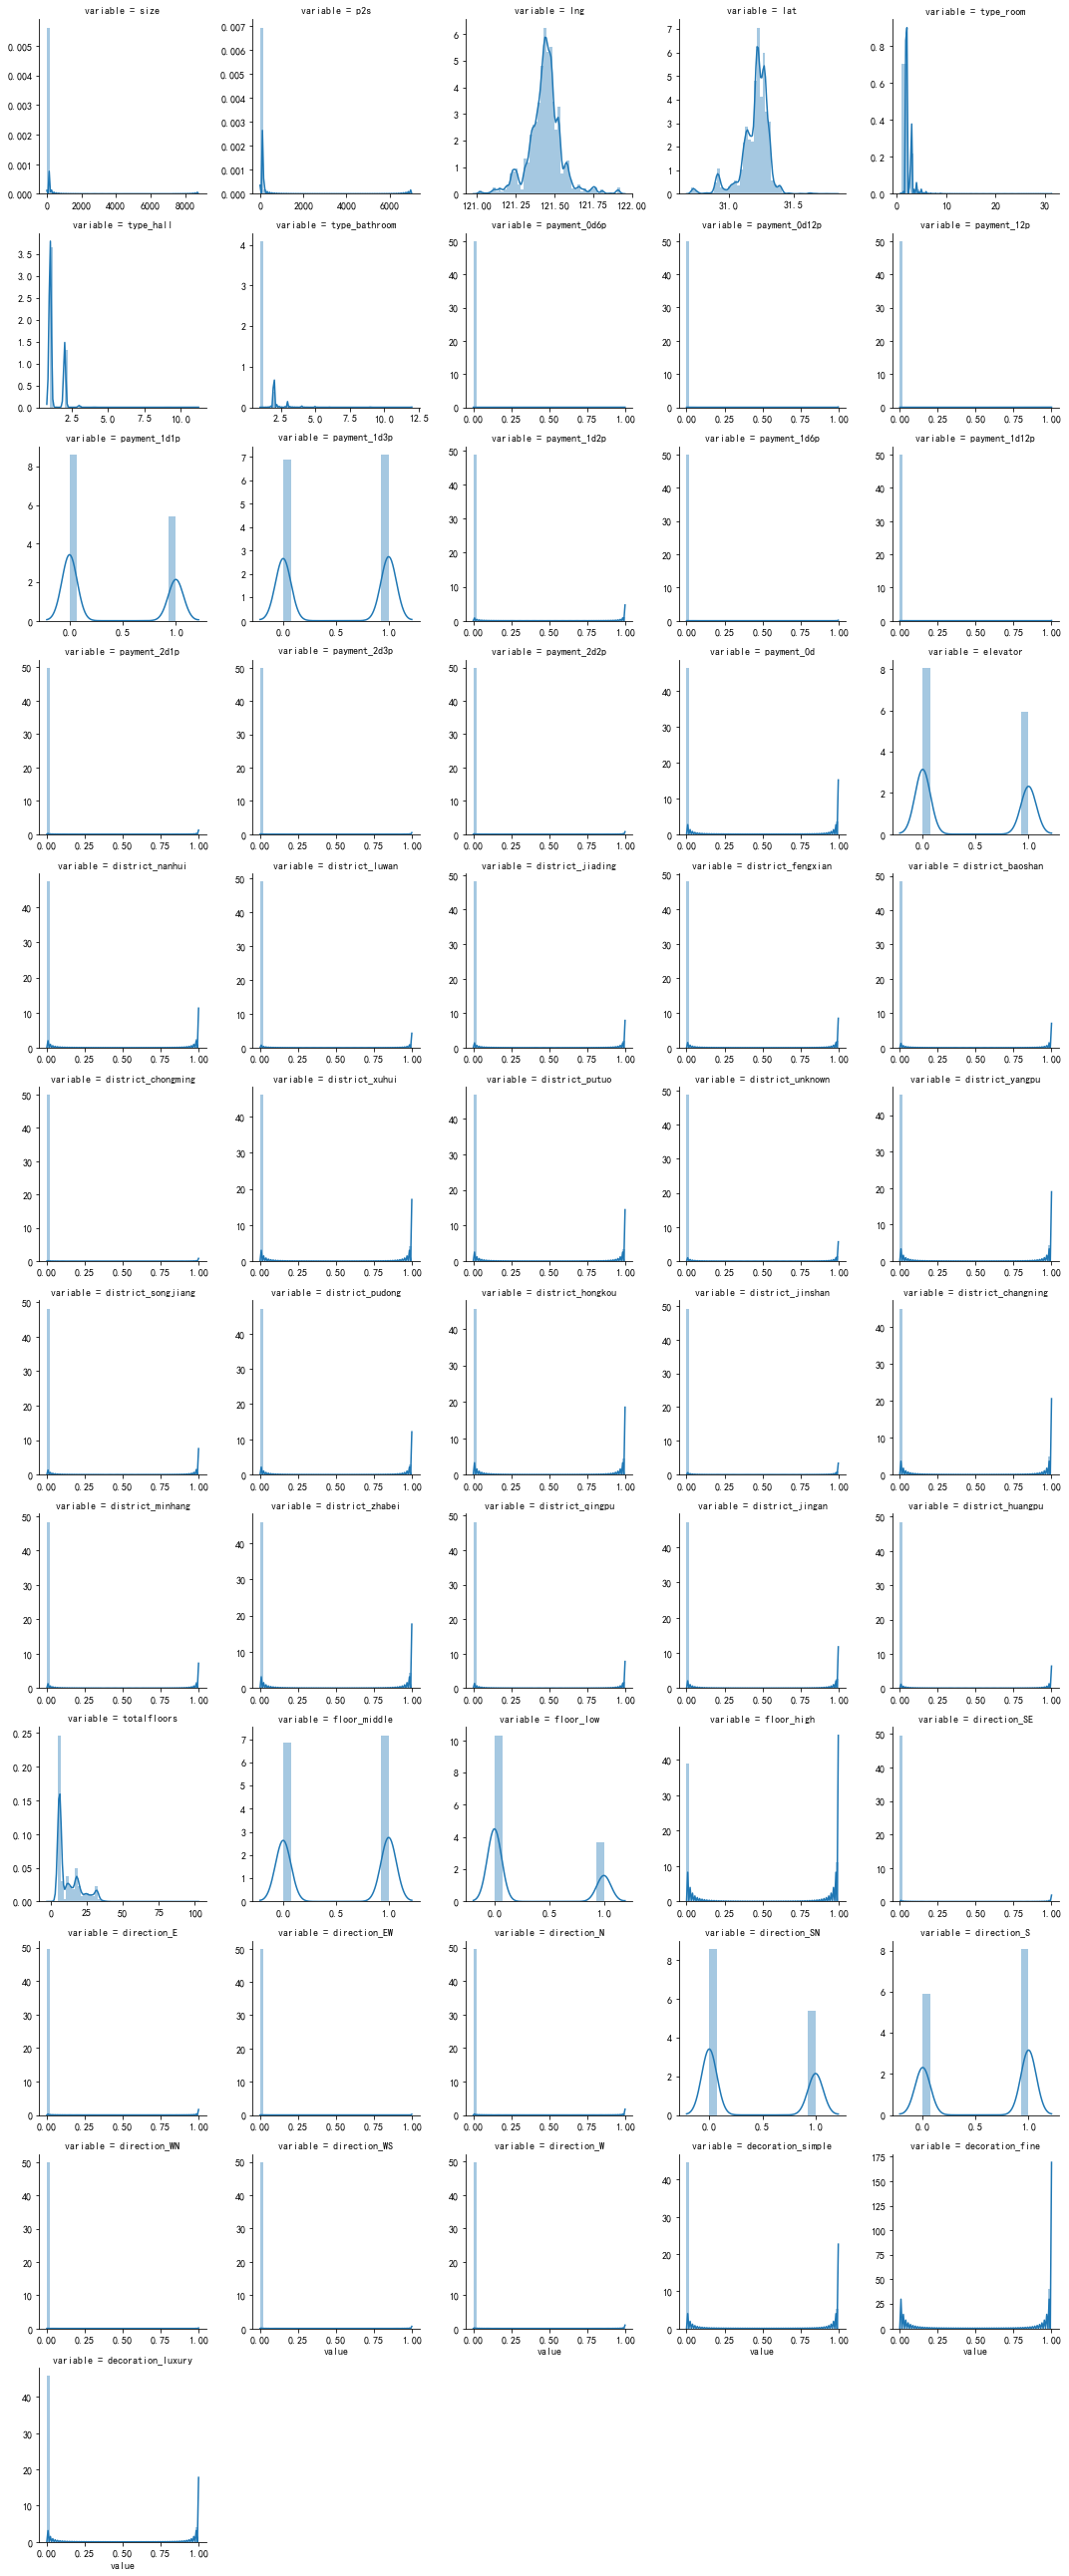

In [25]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object'and  df.dtypes[f] != 'str']
quantitative.remove('price')
f = pd.melt(df, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

In [26]:
from scipy.stats import norm, skew #for some statistics
skewed_feats = df[quantitative].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(50)

,Skew
payment_0d6p,140.861634
payment_12p,99.596687
p2s,63.527200
payment_1d12p,57.484783
payment_0d12p,46.925478
size,39.174242
direction_WN,37.609849
payment_1d6p,37.609849
direction_EW,31.452361
payment_2d3p,21.166600


In [27]:
# drop extreme skewed distributions
df.drop(df[(df["payment_12p"]==1) | (df["payment_0d6p"]==1 ) | (df["payment_0d6p"]==1)
           |(df["payment_0d12p"]==1)|(df["direction_WN"]==1)|(df["payment_1d6p"]==1)
          |(df["payment_1d12p"]==1)|(df["direction_EW"]==1)].index,inplace=True)

In [28]:
df=df.drop(["payment_12p","payment_0d6p","payment_0d6p","payment_0d12p","direction_WN","payment_1d6p",
            "payment_1d12p","direction_EW"],axis=1)

### handling outliers and missing values

(0, 50000)

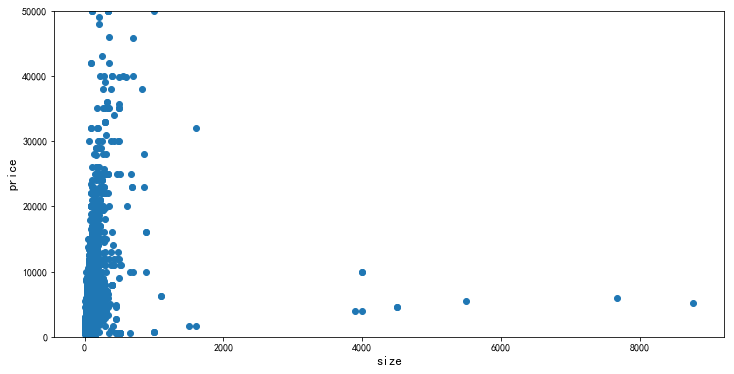

In [29]:
#plot the price & rents before restriction
plt.figure(figsize=(12,6))
plt.scatter(x=df['size'], y=df['price'])
plt.xlabel("size", fontsize=13)
plt.ylabel("price", fontsize=13)
plt.ylim(0,50000)

In [30]:
#drop units with size >200 and price >20000
df= df[(df["size"]<200)&(df["price"]<20000)]
df.drop(df[(df["size"]>150)&(df["price"]<5000)].index,inplace=True)
df.drop(df[(df["size"]<110)&(df["price"]>17500)].index,inplace=True)
df.drop(df[(df["房屋配套(device)"]=='[]')].index,inplace=True)

In [31]:
#fill in missing values
df['totalfloors'].fillna((df['totalfloors'].mean()), inplace=True)
df['type_room'].fillna((df['type_room'].mean()), inplace=True)
df['type_hall'].fillna((df['type_hall'].mean()), inplace=True)
df['type_bathroom'].fillna((df['type_bathroom'].mean()), inplace=True)

In [32]:
df=df.dropna(axis=0,how='any')
df = df.reset_index(drop=True)

In [33]:
df.shape

(18424, 70)

(0, 20000)

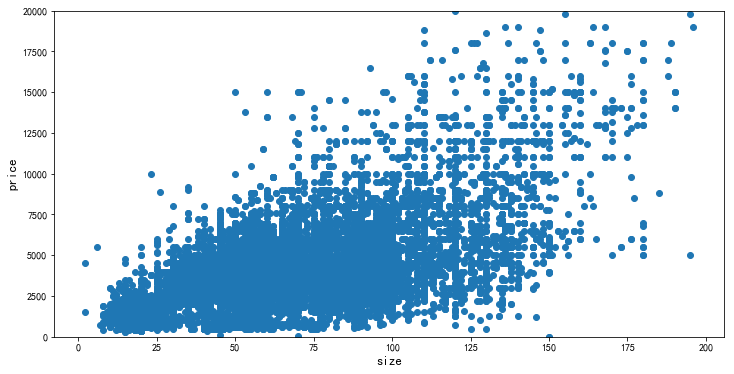

In [34]:
#plot the price & rents scatter plot after restriction
plt.figure(figsize=(12,6))
plt.scatter(x=df['size'], y=df['price'])
plt.xlabel("size", fontsize=13)
plt.ylabel("price", fontsize=13)
plt.ylim(0,20000)

In [35]:
df.head()

,爬取时间(__time),发布时间(publish_time),价格(price),付款方式(price_type),户型(type),面积(size),朝向(direction),楼层(floor),电梯情况(elevator),装修情况(decoration),...,direction_SE,direction_E,direction_N,direction_SN,direction_S,direction_WS,direction_W,decoration_simple,decoration_fine,decoration_luxury
0,2018-10-31 22:58:35,2018-10-31 22:56:35,¥ 4000 /月,押一付三,2室1厅1卫,整租78㎡,南向,中层/共6层,无电梯,精装修,...,0,0,0,0,1,0,0,0,1,0
1,2018-10-31 22:40:29,2018-10-31 22:34:48,¥ 4000 /月,押一付三,2室1厅1卫,整租78㎡,南向,中层/共6层,无电梯,精装修,...,0,0,0,0,1,0,0,0,1,0
2,2018-10-31 20:34:24,2018-10-31 10:37:40,¥ 4500 /月,押一付三,2室1厅1卫,整租76㎡,南北向,低层/共6层,无电梯,精装修,...,0,0,0,1,0,0,0,0,1,0
3,2018-10-31 22:58:33,2018-10-31 22:56:29,¥ 5500 /月,押一付一,3室2厅1卫,整租115㎡,南向,中层/共30层,有电梯,精装修,...,0,0,0,0,1,0,0,0,1,0
4,2018-10-31 22:58:28,2018-10-31 22:57:10,¥ 5300 /月,押一付一,3室2厅1卫,整租102㎡,南向,中层/共30层,有电梯,精装修,...,0,0,0,0,1,0,0,0,1,0


### Import transportation data

In [36]:
import shapefile
sf = shapefile . Reader ("上海公交/上海市市辖区_公交站点.shp")
metro = shapefile . Reader ("上海地铁/站点.shp")
Shapes = sf.shapes( )
Shape = sf.shape(0)
sr = sf.shapeRecords()

In [37]:
lng=df['lng'].tolist()
lat=df['lat'].tolist()

In [38]:
# Calculate the number of stops near house units
def shpProcessing (sf,colName,dia):
    Shapes = sf.shapes( )
    Shape = sf.shape(0)
    sr = sf.shapeRecords()
    lngB=[]
    latB=[]
    busname=[]
    for i in sr:
        lngB.append(float(i.shape.points[0][0]))
        latB.append(float(i.shape.points[0][1]))
        busname.append(i.record[0])
    d={'Name':busname,'lng':lngB,'lat':latB}
    dfbus=pd.DataFrame(d)
    dfbus['lng']=dfbus['lng'].apply(lambda x:x+0.004281)
    dfbus['lat']=dfbus['lat'].apply(lambda x:x-0.002211)
    dfbus['no']=10
    gps=zip(lngB, latB)
    gpsSet=set(gps)
    thisCommunity=""
    thisNear=0
    
    for i in range(len(lng)):
        num=0
        if (i%100==0):
            print("Progress: {0}%".format(math.ceil(100*i / len(lng)) ), end="\r")

        if( thisCommunity==df.iloc[i]['name'] ):
                num=thisNear
        else:
            for j in gpsSet:
                dis=(lng[i]-j[0])**2+(lat[i]-j[1])**2
                if dis<dia:
                    num+=1
            thisNear=num  
        thisCommunity=df.iloc[i]['name']
        df.loc[i,colName]=int(thisNear)
    #     print(df.iloc[i]['name']+" "+str(thisNear))

In [42]:
#Compute metro stops nearby

shpProcessing(metro,"metro",0.0001)

In [43]:
#Compute bus stops nearby
shpProcessing(sf,"bus",0.00002)

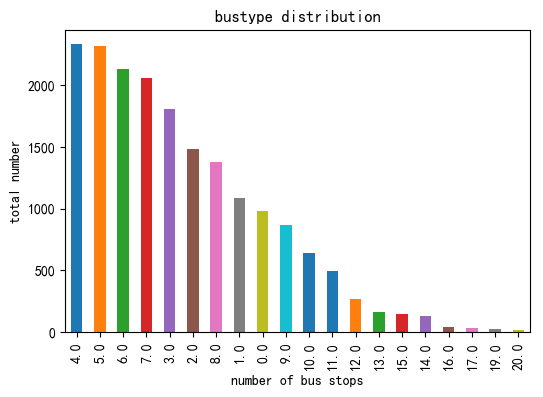

In [44]:
#bustype distribution plot
bustype = df['bus'].value_counts()
mpl.rcParams['axes.unicode_minus'] = False 
asd,sdf = plt.subplots(1,1,dpi=100)
bustype.head(20).plot(kind='bar',x='bustype',y='price',title='bustype distribution',ax=sdf)
plt.xlabel('number of bus stops')  
plt.ylabel('total number')  
plt.show()

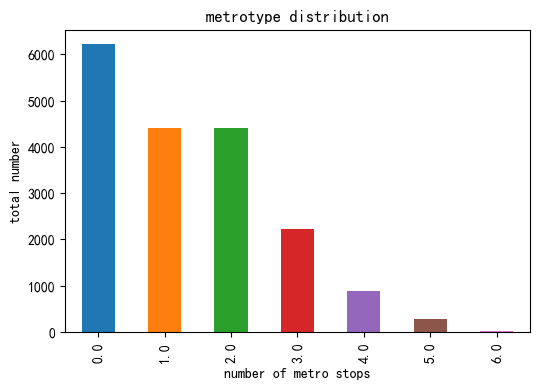

In [45]:
#metrotype distribution plot
metrotype = df['metro'].value_counts()
mpl.rcParams['axes.unicode_minus'] = False 
asd,sdf = plt.subplots(1,1,dpi=100)
metrotype.head(20).plot(kind='bar',x='metrotype',y='price',title='metrotype distribution',ax=sdf)
plt.xlabel('number of metro stops')  
plt.ylabel('total number')  
plt.show()

In [46]:
#get house device features
def deviceIn(device, arry):
    l=len(arry)
    if (l>0):
        if ( device in arry):
             return 1
        else:
             return 0
def deviceProcessing(device,colName,df):   
        df[colName]=df['房屋配套(device)'].apply(lambda x: deviceIn(device,x))
        return df

In [47]:
df=deviceProcessing('"独立阳台"',"balcony",df)
df=deviceProcessing('"冰箱"',"refrige",df)
df=deviceProcessing('"洗衣机"',"laundry",df)
df=deviceProcessing('"可做饭"',"kitchen",df)
df=deviceProcessing('"空调"',"AC",df)

In [48]:
df.head()

,爬取时间(__time),发布时间(publish_time),价格(price),付款方式(price_type),户型(type),面积(size),朝向(direction),楼层(floor),电梯情况(elevator),装修情况(decoration),...,decoration_simple,decoration_fine,decoration_luxury,metro,bus,balcony,refrige,laundry,kitchen,AC
0,2018-10-31 22:58:35,2018-10-31 22:56:35,¥ 4000 /月,押一付三,2室1厅1卫,整租78㎡,南向,中层/共6层,无电梯,精装修,...,0,1,0,1.0,5.0,1,1,1,1,1
1,2018-10-31 22:40:29,2018-10-31 22:34:48,¥ 4000 /月,押一付三,2室1厅1卫,整租78㎡,南向,中层/共6层,无电梯,精装修,...,0,1,0,1.0,5.0,1,1,1,1,1
2,2018-10-31 20:34:24,2018-10-31 10:37:40,¥ 4500 /月,押一付三,2室1厅1卫,整租76㎡,南北向,低层/共6层,无电梯,精装修,...,0,1,0,1.0,5.0,1,1,1,1,1
3,2018-10-31 22:58:33,2018-10-31 22:56:29,¥ 5500 /月,押一付一,3室2厅1卫,整租115㎡,南向,中层/共30层,有电梯,精装修,...,0,1,0,1.0,4.0,1,1,1,1,1
4,2018-10-31 22:58:28,2018-10-31 22:57:10,¥ 5300 /月,押一付一,3室2厅1卫,整租102㎡,南向,中层/共30层,有电梯,精装修,...,0,1,0,1.0,4.0,1,1,1,1,1


In [49]:
df.columns

Index(['爬取时间(__time)', '发布时间(publish_time)', '价格(price)', '付款方式(price_type)',
       '户型(type)', '面积(size)', '朝向(direction)', '楼层(floor)', '电梯情况(elevator)',
       '装修情况(decoration)', 'name', '地铁(subway)', '所在地址(location)',
       '房屋配套(device)', '房屋描述(details)', '小区信息(community_details)', 'price',
       'size', 'p2s', 'address', 'lng', 'lat', 'adname', 'shopid', 'type_room',
       'type_hall', 'type_bathroom', 'payment_1d1p', 'payment_1d3p',
       'payment_1d2p', 'payment_2d1p', 'payment_2d3p', 'payment_2d2p',
       'payment_0d', 'elevator', 'district', 'district_nanhui',
       'district_luwan', 'district_jiading', 'district_fengxian',
       'district_baoshan', 'district_chongming', 'district_xuhui',
       'district_putuo', 'district_unknown', 'district_yangpu',
       'district_songjiang', 'district_pudong', 'district_hongkou',
       'district_jinshan', 'district_changning', 'district_minhang',
       'district_zhabei', 'district_qingpu', 'district_jingan',
       'district_h

### drop columns and take log

In [50]:
finalCopy=df.drop(columns=['爬取时间(__time)','发布时间(publish_time)','价格(price)','付款方式(price_type)','户型(type)',
                      '面积(size)','朝向(direction)','楼层(floor)','电梯情况(elevator)','装修情况(decoration)',
                      '地铁(subway)','所在地址(location)','房屋配套(device)','房屋描述(details)','小区信息(community_details)',
                      'p2s','address','adname','shopid','district'], axis=1)

In [51]:
df = df.drop(columns=['爬取时间(__time)','发布时间(publish_time)','价格(price)','付款方式(price_type)','户型(type)',
                      '面积(size)','朝向(direction)','楼层(floor)','电梯情况(elevator)','装修情况(decoration)','name',
                      '地铁(subway)','所在地址(location)','房屋配套(device)','房屋描述(details)','小区信息(community_details)',
                      'p2s','address','lng','lat','adname','shopid','district'], axis=1)

In [52]:
df.columns

Index(['price', 'size', 'type_room', 'type_hall', 'type_bathroom',
       'payment_1d1p', 'payment_1d3p', 'payment_1d2p', 'payment_2d1p',
       'payment_2d3p', 'payment_2d2p', 'payment_0d', 'elevator',
       'district_nanhui', 'district_luwan', 'district_jiading',
       'district_fengxian', 'district_baoshan', 'district_chongming',
       'district_xuhui', 'district_putuo', 'district_unknown',
       'district_yangpu', 'district_songjiang', 'district_pudong',
       'district_hongkou', 'district_jinshan', 'district_changning',
       'district_minhang', 'district_zhabei', 'district_qingpu',
       'district_jingan', 'district_huangpu', 'totalfloors', 'floor_middle',
       'floor_low', 'floor_high', 'direction_SE', 'direction_E', 'direction_N',
       'direction_SN', 'direction_S', 'direction_WS', 'direction_W',
       'decoration_simple', 'decoration_fine', 'decoration_luxury', 'metro',
       'bus', 'balcony', 'refrige', 'laundry', 'kitchen', 'AC'],
      dtype='object')

In [53]:
df.to_csv("final_data.csv")

In [54]:
# df = pd.read_csv("final_data.csv")
# df.shape

### get X and Y matrix, also split training and testing data

In [55]:
def getXY(df2): 
    df2['price'] = np.log(df2['price'])
    df2['size'] = np.log(df2['size'])
    X = df2.drop(columns = ['price']).values
    Y = df2['price'].values
    return X,Y

In [56]:
X,Y=getXY(df)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

### Feature Selection using Lasso

In [57]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.001)
lasso.fit(X_train,Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
XX = df.drop(columns = ['price'])

In [59]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=XX.columns)

In [60]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
size,0.648076
decoration_luxury,0.320161
district_jingan,0.284105
district_changning,0.219652
type_hall,0.207411
payment_1d3p,0.186239
district_putuo,0.185838
AC,0.138893
district_huangpu,0.110254
district_xuhui,0.105233


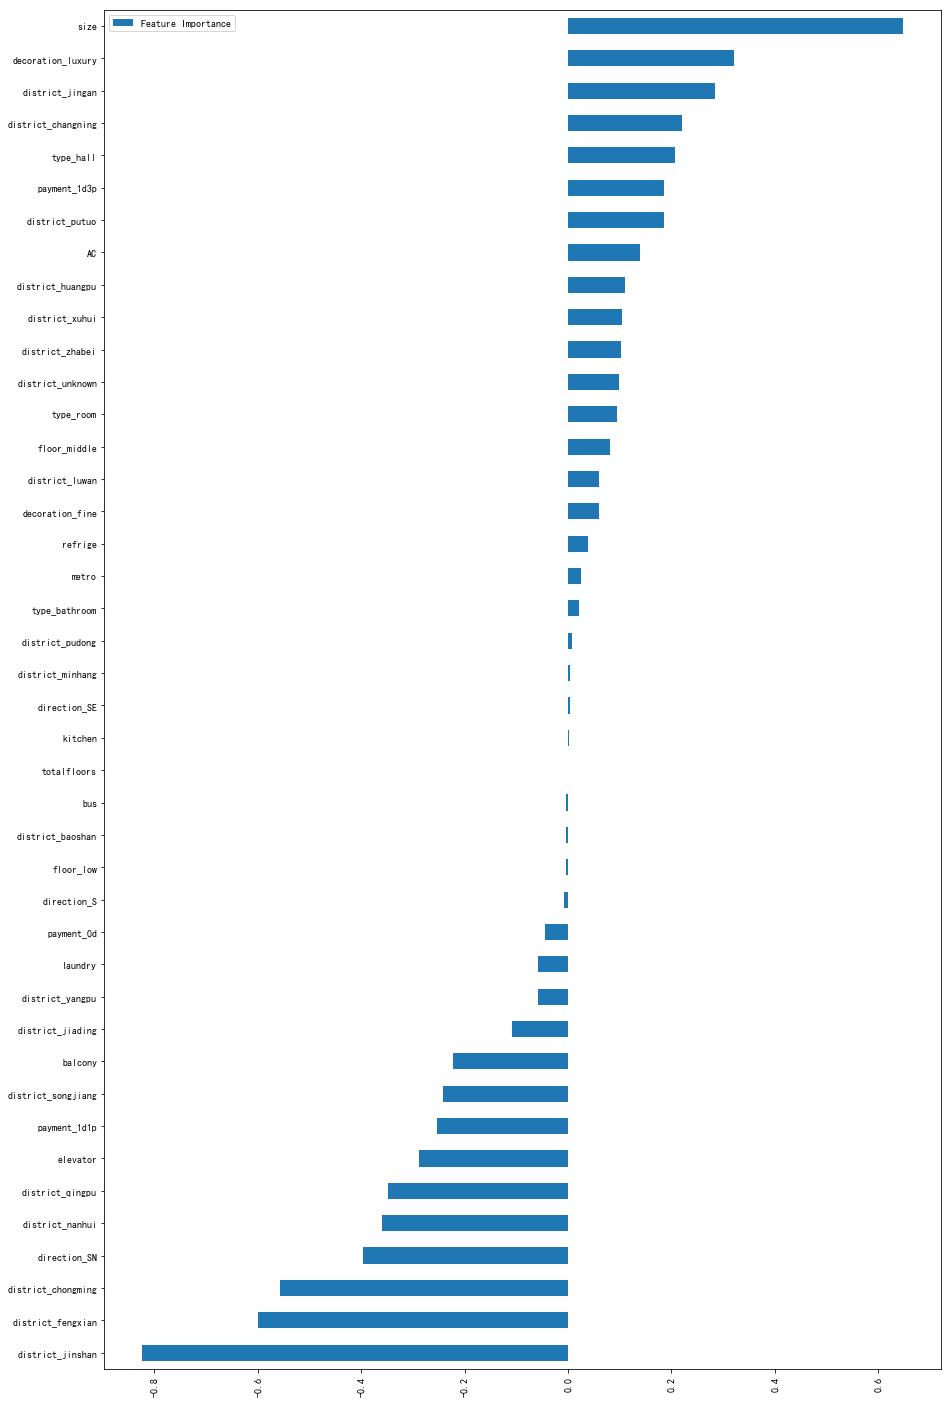

In [61]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [62]:
# from sklearn.decomposition import PCA, KernelPCA
# pca = PCA(n_components=60)
# X_train=pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

PCA will lead to a worse performance, so we ignore it

In [63]:
X_train.shape

(12344, 53)

## Modeling

In [64]:
from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [65]:
#define robustscaler function
def scaleX(X_tr,X_te):
    scaler = RobustScaler()
    X_tr = scaler.fit(X_tr).transform(X_tr)
    X_te = scaler.transform(X_te)
    return X_tr,X_te

In [66]:
X_train, X_test = scaleX(X_train,X_test)

In [67]:
# define cross validation strategy and return rmse
def rmse_cv(model,X,y): 
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [68]:
#get result of 13 default models
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
print("   mse_train" + " mse_std" + " mse_test")
for name, model in zip(names, models):
    score = rmse_cv(model, X_train, Y_train)
    model.fit(X_train,Y_train.ravel())
    Y_hat = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(Y_test,Y_hat))
    print("{}: {:.6f}, {:.4f}, {:.4f}".format(name,score.mean(),score.std(),rmse_test))

   mse_train mse_std mse_test
LR: 0.476780, 0.0146, 0.4866
Ridge: 0.476732, 0.0147, 0.4866
Lasso: 0.511869, 0.0142, 0.5212
RF: 0.273922, 0.0195, 0.2661
GBR: 0.339933, 0.0141, 0.3459
SVR: 0.342071, 0.0158, 0.3586
LinSVR: 0.534653, 0.0149, 0.5417
Ela: 0.477826, 0.0150, 0.4877
SGD: 0.495869, 0.0144, 0.5050
Bay: 0.476730, 0.0147, 0.4866
Ker: 0.376466, 0.0368, 0.3732
Extra: 0.267813, 0.0180, 0.2422
Xgb: 0.340574, 0.0152, 0.3491


### Hyperparameter tuning (for the six best models)

In [ ]:
#define a grid search method
class grid_search():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,Y,X_test,Y_test,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,Y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score']])
        Y_hat = grid_search.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(Y_test,Y_hat))
        print("Score of best params using test data: ")
        print(rmse_test)

In [ ]:
#define a random search method
class random_search():
    def __init__(self,model):
        self.model = model
    
    def random_get(self,X,Y,X_test,Y_test,param_grid):
        random_search = RandomizedSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        random_search.fit(X,Y)
        print(random_search.best_params_, np.sqrt(-random_search.best_score_))
        random_search.cv_results_['mean_test_score'] = np.sqrt(-random_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(random_search.cv_results_)[['params','mean_test_score']])
        Y_hat = random_search.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(Y_test,Y_hat))
        print("Score of best params using test data: ")
        print(rmse_test)

### SVR 

In [ ]:
#SVR random search
random_search(SVR()).random_get(X_train,Y_train,X_test,Y_test,{'C':[0.01, 0.1, 1, 10,20,50],'kernel':["rbf"],"gamma":[ 0.01, 0.1, 1]})

In [ ]:
#SVR grid search
# grid_search(SVR()).grid_get(X_train,Y_train,X_test,Y_test,{'C':[5,10,13,15],'kernel':["rbf"],"gamma":[0.01,0.05,0.1,0.15,0.2]})

### Kernal Ridge

In [ ]:
#Kernal random search
param_random={'alpha':[0.01,0.05,0.1,0.2,0.3,0.5], 'kernel':["polynomial"], 'degree':[2,3,4],'coef0':[0.8,1,1.2,1.5,2,2.5,3]}
random_search(KernelRidge()).random_get(X_train,Y_train,X_test,Y_test,param_random)

In [ ]:
#Kernal grid search
# param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}
# grid_search(KernelRidge()).grid_get(X_train,Y_train,X_test,Y_test,param_grid)

### Random Forest

In [ ]:
#Random forest random search
param_random={'n_estimators':[200,400,600], 'max_features':['auto', 'sqrt'], 'max_depth':[10,20,None],
              'min_samples_split':[2, 5, 10],'min_samples_leaf':[1, 2, 4],'bootstrap':[True, False]}
random_search(RandomForestRegressor()).random_get(X_train,Y_train,X_test,Y_test,param_random)

In [ ]:
# Random Forest
# Grid Search
# param_grid={'n_estimators':[100,200,300], 'max_features':['auto', 'sqrt'], 'max_depth':[10,20,30],'min_samples_split':[1,2,3,5, 10],'min_samples_leaf':[1, 2],'bootstrap':[True, False]}
# grid_search(RandomForestRegressor()).grid_get(X_train,Y_train,X_test,Y_test,param_grid)

### GBR (gradient boosting)

In [ ]:
#GBR random search
param_random={'learning_rate':[1, 0.75,0.6,0.5,0.4,0.3,0.25,0.1,0.05,0.01], 
              'n_estimators':[1,20,50,75,100,150,200], 'max_depth':[1,2,4,6,10,15,20],
              'min_samples_split':[2,3,5,10,12,15,18,20,25,30],'min_samples_leaf':[0.1,0.2,1,2,3,4,5]}
random_search(GradientBoostingRegressor()).random_get(X_train,Y_train,X_test,Y_test,param_random)

In [ ]:
#GBR grid search
# param_grid={'learning_rate':[1, 0.75,0.6,0.5,0.4,0.3,0.25,0.1,0.05,0.01], 
#               'n_estimators':[25,50,75,100], 'max_depth':[5,10,15],
#               'min_samples_split':[2,5,10,15],'min_samples_leaf':[1,3,4,5]}
# grid_search(GradientBoostingRegressor()).grid_get(X_train,Y_train,X_test,Y_test,param_grid)

### XGB

In [ ]:
#XGB random search
param_random={ 'max_depth':[5,6,7,8,9,10],
               'min_child_weight':range(1,10,2),
               'gamma':[0,0.05,0.1,0.2],
               'subsample':[0.6,0.7,0.8,0.9],
               'colsample_bytree':[0.6,0.8,0.85,0.9,1,2,5],
               'n_estimators':[200,400,600,800,1000], 
               'learning_rate':[0.01,0.05,0.75,0.1,0.3,0.5,1]}
random_search(XGBRegressor()).random_get(X_train,Y_train,X_test,Y_test,param_random)

In [ ]:
#XGB grid search
# param_grid={ 'max_depth':[5,7,10,12,15],
#                'min_child_weight':range(1,5,10),
#                'gamma':[0,0.05,0.1],
#                'subsample':[0.6,0.7,0.8],
#                'colsample_bytree':[0.6,0.8,1,2,5],
#                'n_estimators':[200,600,1000,1200], 
#                'learning_rate':[0.01,0.75,0.1,0.5]}
# grid_search(XGBRegressor()).grid_get(X_train,Y_train,X_test,Y_test,param_grid)

### ExtraTree

In [ ]:
#ExtraTree random search
param_random={'n_estimators': range(30,200,5),
              'max_features': range(15,50,2),
              'min_samples_leaf': range(1,10,1),
               'min_samples_split': range(5,100,4),   
}
random_search(ExtraTreesRegressor()).random_get(X_train,Y_train,X_test,Y_test,param_random)

In [ ]:
#ExtraTree grid search
# param_grid={'n_estimators': [25,50,75,100,125],
#               'max_features': [20,25,30,40,43,50],
#               'min_samples_leaf': [1,2,5,10],
#                'min_samples_split': [5,10,15,20,25,50],   
# }
# grid_search(ExtraTreesRegressor()).grid_get(X_train,Y_train,X_test,Y_test,param_grid)

### Ensemble Method

#### 1. Average weight for all six models

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [70]:
svr = SVR(gamma= 0.1,kernel='rbf',C=10)
ker = KernelRidge(alpha=0.1 ,kernel='polynomial',degree=3 ,coef0=2)
rf = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=False)
gbr = GradientBoostingRegressor(n_estimators=75, min_samples_split=3, min_samples_leaf=4, max_depth=10, learning_rate=0.1)
xgb = XGBRegressor(subsample=0.7, n_estimators= 1000, min_child_weight= 1, max_depth= 10, learning_rate= 0.1, gamma= 0.05, colsample_bytree= 1)
extra = ExtraTreesRegressor(n_estimators=75, min_samples_split=17, min_samples_leaf=1, max_features=43)

In [71]:
# assign weights based on their gridsearch score
w1 = 0.13
w2 = 0.02
w3 = 0.2
w4 = 0.25
w5 = 0.2
w6 = 0.2

In [72]:
weight_avg = AverageWeight(mod = [svr,ker,rf,gbr,xgb,extra],weight = [w1,w2,w3,w4,w5,w6])

In [73]:
rmse_cv(weight_avg,X_train,Y_train),  rmse_cv(weight_avg,X_train,Y_train).mean()

(array([0.27106665, 0.2300379 , 0.23696302, 0.2108526 , 0.24962888]),
 0.23949981420561875)

In [ ]:
#weight_avg testing score
weight_avg.fit(X_train,Y_train.ravel())
Y_hat = weight_avg.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test,Y_hat))
print("Score of best params using test data: ")
print(rmse_test)

#### 2. average weight using two models (random forest + xgb)

In [ ]:
weight_avg = AverageWeight(mod = [rf,xgb],weight=[0.5,0.5])

In [ ]:
rmse_cv(weight_avg,X_train,Y_train),  rmse_cv(weight_avg,X_train,Y_train).mean()

In [ ]:
weight_avg.fit(X_train,Y_train.ravel())
Y_hat = weight_avg.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test,Y_hat))
print("Score of best params using test data: ")
print(rmse_test)

#### 3. Stacking

In [81]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)

In [82]:
# imputer first, otherwise stacking won't work
from sklearn.preprocessing import Imputer
a = Imputer().fit_transform(X_train)
b = Imputer().fit_transform(Y_train.reshape(-1,1)).ravel()

In [ ]:
stack_model = stacking(mod=[svr,ker,rf,gbr,xgb,extra],meta_model=ker)

In [ ]:
print(rmse_cv(stack_model,a,b))
print(rmse_cv(stack_model,a,b).mean())

In [102]:
#weight_avg testing score
stack_model.fit(X_train,Y_train.ravel())
Y_hat = stack_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test,Y_hat))
print("Score of best params using test data: ")
print(rmse_test)

Score of best params using test data: 
0.21575793312137803


This is the final RMSE score on the test set. We skip several time consuming cells.

### Neural Network

In [ ]:
import keras
from keras import models
from keras import layers
from keras import regularizers

model = keras.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
history = model.fit(X_train,Y_train,epochs=100,verbose=0,validation_data=(X_test,Y_test))

In [ ]:
#loss plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,label='Training loss')
plt.plot(epochs,val_loss,label='Validation loss')

print ("training RMSE: ")
print(np.sqrt(loss[-6:-1]))
print("validation RMSE: ")
print(np.sqrt(val_loss)[-6:-1])

plt.title('Training and validation loss')
plt.legend()

In [ ]:
#mae plot
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
epochs = range(1,len(mae)+1)

plt.plot(epochs,mae,label='Training mae')
plt.plot(epochs,val_mae,label='Validation mae')

plt.title('Training and validation mae')
plt.legend()

### RMSPE and Deviation Analysis


In [75]:
def getPre(X):
    pred=stack_model.predict(X)
    return np.exp(pred)

In [76]:
def RMSPE(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_pred)), axis=0))
    return loss

In [77]:
def RMSE(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square((y_true - y_pred)), axis=0))
    return loss

In [78]:
def RMSPEI(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays for each element.
    '''
    loss = np.sqrt(np.square(((y_true - y_pred) / y_pred)))

    return loss

In [79]:
lng,lat=finalCopy.lng,finalCopy.lat
final=finalCopy.drop(["lng","lat",'name'], axis=1)
X_whole,Y_whole=getXY(final)
X_whole,X_r=scaleX(X_whole,X_whole[0:1])

In [84]:
stack_model = stacking(mod=[svr,ker,rf,gbr,xgb,extra],meta_model=ker)

In [85]:
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.1, coef0=2, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), KernelRidge(alpha=0.1, coef0=2, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None), RandomForestRegressor(bootstrap=False, criterion='...estimators=75, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)])

In [88]:
pr_test=getPre(X_test)
rmspe=RMSPE(np.exp(Y_test),pr_test)
rmspei=RMSPEI(np.exp(Y_test),pr_test)

In [89]:
mean = np.mean(rmspei)
st_dev = np.std(rmspei)

print("The mean is "+str(mean))
print("The standard deviation is "+str(st_dev))

The mean is 0.14537607285426613
The standard deviation is 0.46076338008126627


In [90]:
rmse=RMSE(Y_test,np.log(pr_test))
print(rmse)

0.21851209701445187


This reports the RMSE score on the testing set

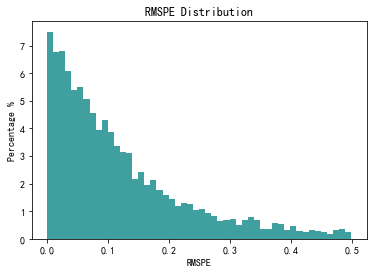

In [91]:
new_x = []
for x in rmspei:
    if  x < 0.5:
        new_x.append(x)
n, bins, patches = plt.hist(new_x, 50, density=1, facecolor='teal', alpha=0.75)
plt.title('RMSPE Distribution')    
plt.xlabel('RMSPE') 
plt.ylabel('Percentage %')
plt.show()

Now we use the whole dataset to run the model

In [92]:
pr_whole=getPre(X_whole)
rmspe_whole=RMSPE(np.exp(Y_whole),pr_whole)
rmspei_whole=RMSPEI(np.exp(Y_whole),pr_whole)

In [93]:
def deviation(y_true, y_pred):
    '''
    Compute the deviation of prediction from the true rents
    '''
    loss = ((y_pred-y_true) / y_true)/rmspe_whole

    return loss

In [94]:
dev=deviation(np.exp(Y_whole),pr_whole)
finalCopy["rmspei"]=rmspei_whole
finalCopy["dev"]=dev

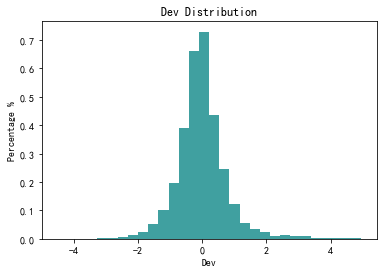

In [105]:
new_x = []
for x in dev:
    if  x < 5:
        new_x.append(x)
n, bins, patches = plt.hist(new_x, 30, density=1, facecolor='teal', alpha=0.75)
plt.title('Dev Distribution')    
plt.xlabel('Dev') 
plt.ylabel('Percentage %')
plt.show()

In [96]:
dev_mean = np.mean(dev)
dev_st_dev = np.std(dev)

print("The mean is "+str(dev_mean))
print("The standard deviation is "+str(dev_st_dev))

The mean is 0.03228006240278276
The standard deviation is 1.9178508530553369


Report the mean and std of our deviation indicator

In [97]:
from pyecharts import Map
from pyecharts import Geo,Style

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "/Users/frederick/anaconda3/lib/python3.6/site-packages/lml/utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


In [98]:
# Choose the units whose deviation is above the threshold
finalCopy=finalCopy[finalCopy["dev"]>1.96]
finalCopy = finalCopy.reset_index(drop=True)

Now plot the undervalued units on Shanghai's map

In [99]:
geo_cities_coords={finalCopy.iloc[i]['name']:[finalCopy.iloc[i]['lng'],finalCopy.iloc[i]['lat']]
                    for i in range(len(finalCopy))}   

In [100]:
attr=finalCopy['name']
value=finalCopy['dev']
style = Style(title_color= "#fff",title_pos = "center",
width = 900,height = 600,background_color = "#404a59")

In [101]:
geo = Geo('Shanghai Housing Diviation',**style.init_style)
geo.add("",attr,value,visual_range=[0,5],symbol_size= 5,
        visual_text_color= "#fff",
        is_visualmap= True,maptype = '上海', 
        geo_cities_coords=geo_cities_coords)
geo.render( 'Diviation.html')
geo